<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit3/Max_BentU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 3 Project

More baseball!

I'll be modelling the stat Game Score for Logan Gilbert, pitcher for the Seattle Mariners, in order to see how good any given Logan Gilbert start is going to be. [Game Score](https://en.wikipedia.org/wiki/Game_score), invented by Bill James, is a stat that measures how good a starting pitcher performs in a start. The higher the number, the better the start. Most starts usually range from 0-100 (with 50 being the average), but lower/higher scores are possible (and have been done).

Let's import some libraries:

In [ ]:
# module's

!pip install preliz
import preliz as pz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

And my data (compiled from baseball-reference.com):

In [ ]:
# data
gilbert_url = 'https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/gilbert_game_score.csv'

# read
gilbert_data = pd.read_csv(gilbert_url)

Here's a histogram of the data, plotted from 0 to 100 (the usual range of scores):

(array([ 0.,  4.,  6.,  5., 26., 26., 29., 19.,  6.,  0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

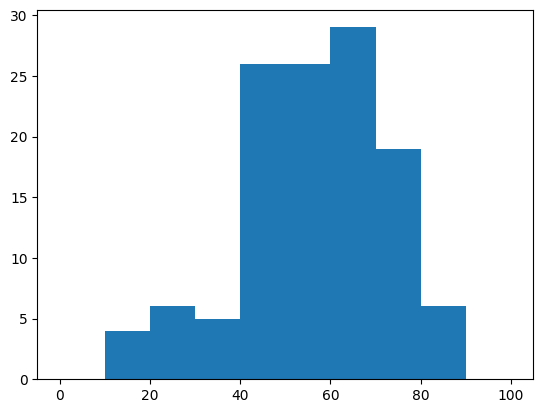

In [ ]:
plt.hist(gilbert_data, range=(0,100))

As you can see, the distribution is largely centered around the 40-70 range, with some scores above or below that range (with most of those outliers being in the 70-80 bin). The modal bin is 60-70, the median of the dataset (calculated elsewhere via Google Sheets) is 58 and the average is 56. This makes sense, given the industry consensus that Gilbert is an above-average pitcher.

My first idea was to model this data with a Weibull distribution, given that the data is skewed leftward and uses discrete positive values (it is extremely unlikely (albeit possible) for a pitcher to have a negative Game Score).

I'm also going to use the SkewNormal and Gamma distributions as priors; the SkewNormal because the data is skewed leftwards and the mean likely is going to be somewhere around 40-70, and the Gamma because the standard deviation is likely going to be somewhere around 5-10 points.

<Axes: >

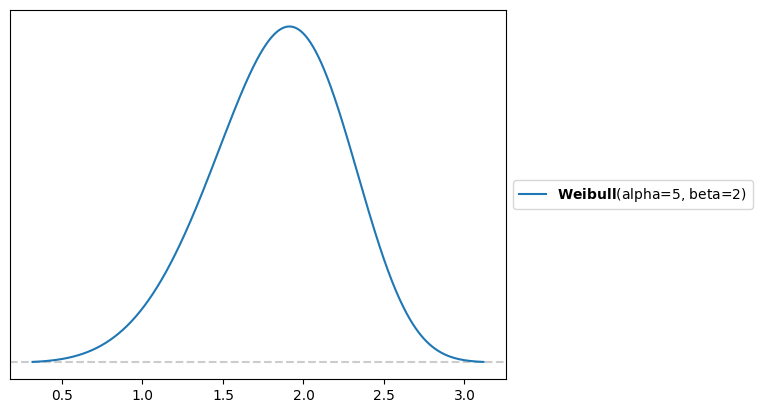

In [ ]:
# these won't actually be the parameters, i'm just showing what it roughly looks like
pz.Weibull(alpha = 5, beta = 2).plot_pdf()

<Axes: >

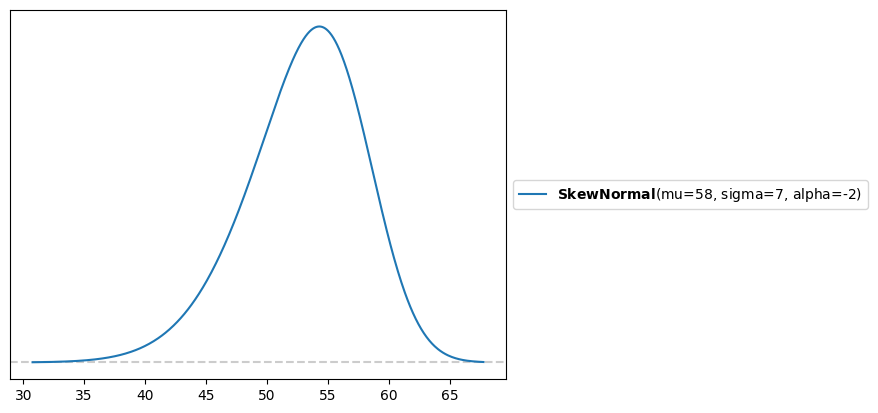

In [ ]:
pz.SkewNormal(mu = 58, sigma = 7, alpha = -2).plot_pdf()

<Axes: >

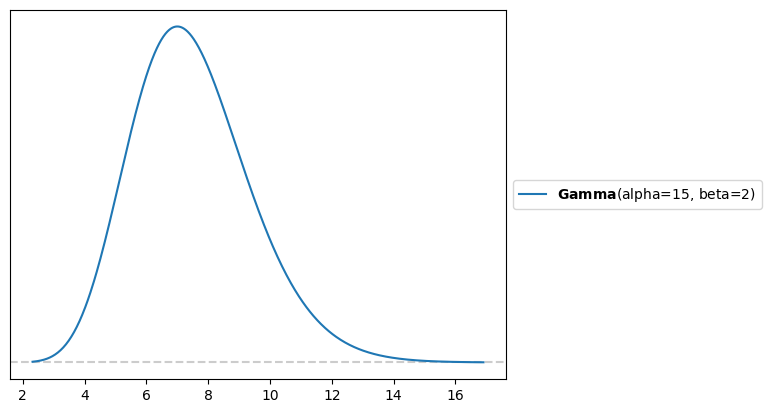

In [ ]:
pz.Gamma(alpha = 15, beta = 2).plot_pdf()

Here's my first attempt at a model:

In [ ]:
# baby's first model

with pm.Model() as gamescore_attempt1:

  # prior 1 (skewnormal)
  a = pm.SkewNormal('alpha', mu = 58, sigma = 7, alpha = -2)

  # prior 2 (gamma)
  b = pm.Gamma('beta', alpha = 15, beta = 2)

  # likelihood (weibull, using skewnormal + gamma as priors)
  w = pm.Weibull('weibull', alpha = a, beta = b, observed=gilbert_data)
  data_gscore = pm.sample()

Output()

Output()

(slight detour to look at my model's priors again)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

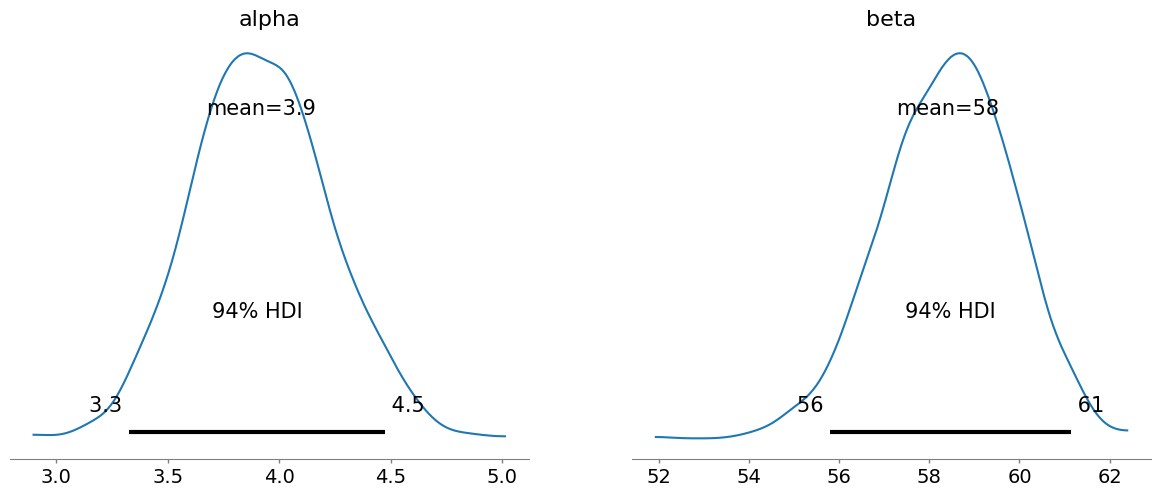

In [ ]:
# look at my priors they're all grown up
az.plot_posterior(data_gscore)

array([[<Axes: >, None],
       [<Axes: xlabel='alpha', ylabel='beta'>, <Axes: >]], dtype=object)

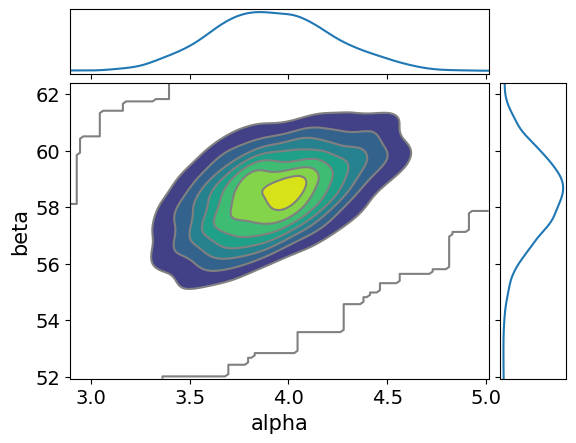

In [ ]:
# the priors are having so much fun together here is how to best optimize their fun
# (secondhand copied from the notes and the textbook)
az.plot_pair(data_gscore, kind='kde', marginals=True)

In [ ]:
# ppc!!!!!! (copied from notes)

pm.sample_posterior_predictive(data_gscore, model=gamescore_attempt1, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='weibull'>

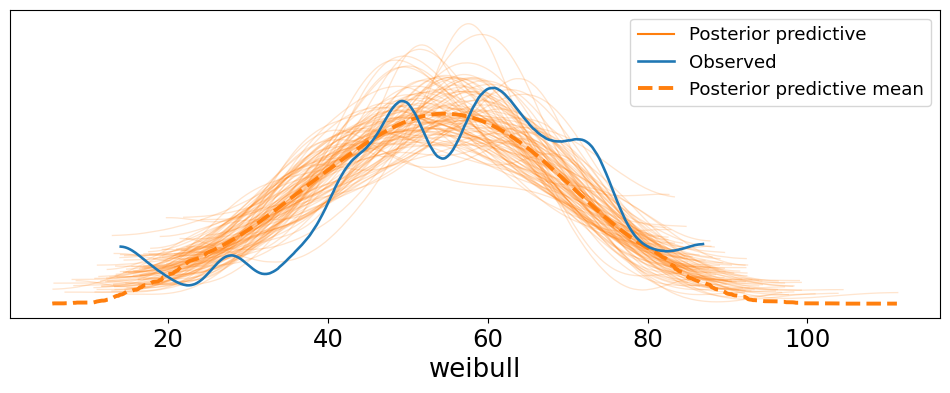

In [ ]:
''' copied from notes '''
# The following code block is taken directly from the textbook BAP3.
# Plots the posterior predictive density overlaid with a smoothed version of the data

az.plot_ppc(data_gscore, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I think this is, for a first attempt, pretty good. It's not perfect, obviously - the model is slightly sleeping on Gilbert; it's overestimating the lower values and underestimating the higher ones. However, it mostly models the patterns of the data well - it's pretty broad, and correctly identifies the shift downwards. On to model #2!

I think my first two priors (representing alpha and beta in the Weibull) are already pretty good, so I'll keep those. Instead of a Weibull, though, I'm just going to use a regular SkewNormal, just to see if it fits better - both the Weibull and SkewNormal distributions could potentially fit this data. My alpha and beta are now going to change to be mu and sigma, respectively, since they represent the same things (location and scale/standard deviation). I'm going to use a shifted Normal for the skew parameter, since outside of the "true" skew being roughly in the same place (in the negatives), the potential skew shouldn't be skewed or anything.

<Axes: >

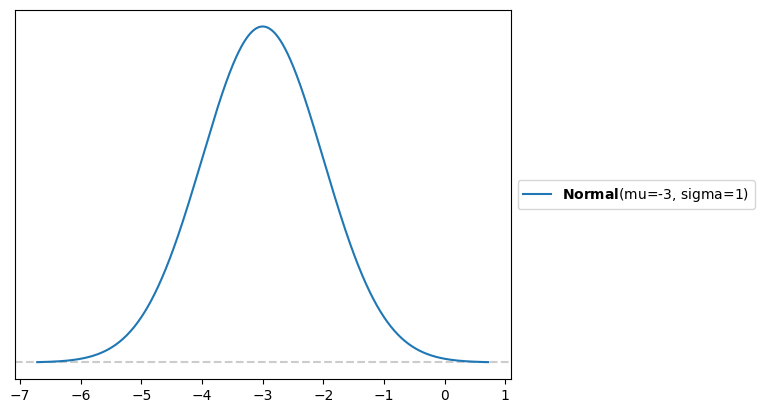

In [ ]:
# Third prior (normal, used for skew)

pz.Normal(mu = -3, sigma = 1).plot_pdf()

In [ ]:
# baby's second model

with pm.Model() as gamescore_attempt2:

  # prior 1 (skewnormal)
  m = pm.SkewNormal('mu', mu = 60, sigma = 7, alpha = -2) # I've changed the mu from 58 to 60 because
                                                          # the model was a little misplaced before
  # prior 2 (gamma)
  s = pm.Gamma('sigma', alpha = 15, beta = 2)

  # prior 3 (skewnormal)
  a = pm.Normal('alpha', mu = -3, sigma = 1)

  # likelihood (skewnormal, using skewnormal + gamma as priors)
  w = pm.SkewNormal('posterior', mu = m, sigma = s, alpha = a, observed=gilbert_data)
  data_gscore2 = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'mu'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

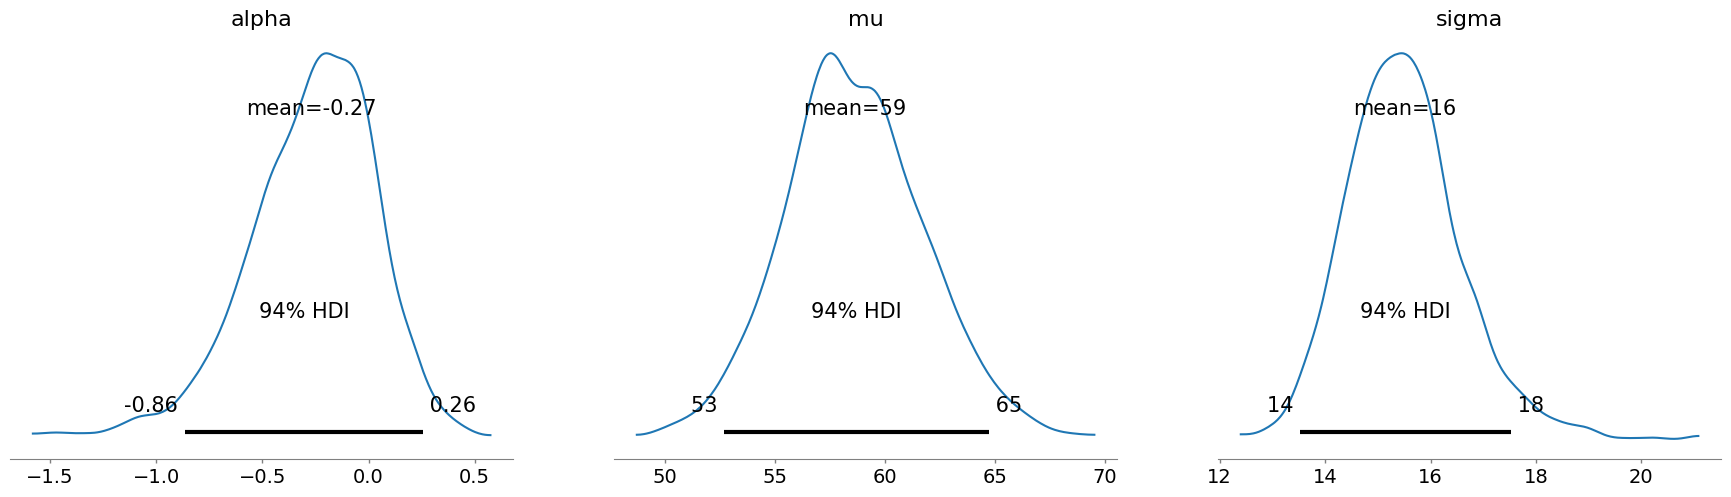

In [ ]:
# parameters picked by priors

az.plot_posterior(data_gscore2)

Interesting, the alpha parameter is different than I was expecting - instead of being definitely skewed left, the model believes that it's mostly unskewed. Let's see if the ppc yells at us:

In [ ]:
# ppc!

pm.sample_posterior_predictive(data_gscore2, model=gamescore_attempt2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

No errors! Yay!

Let's see the posterior predictive mean visualization:

<Axes: xlabel='posterior'>

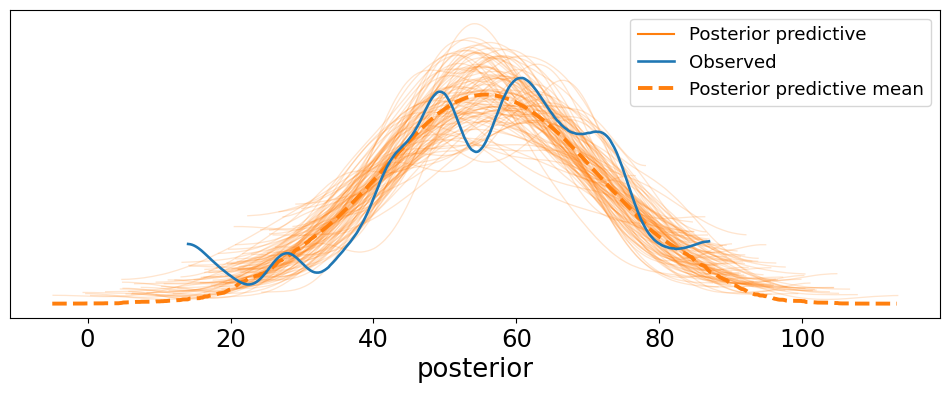

In [ ]:
az.plot_ppc(data_gscore2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

As we can see, the model is basically the same as before, but a little bit better - it underestimates the high values while overestimating the lows, but it matches the overall data better than the Weibull-based model in my opinion.

Looking at our model's parameter information, it projects the mean start to have a game score of 59, a standard deviation of roughly 16 points of game score (meaning roughly two-thirds of starts should fall between 43 and 75), and seemingly negligible skew.

I think this model is good enough. It accurately projects Gilbert as an above-average pitcher on any given start, which makes sense given what we know about him. It also acknowledges the very real possibility of both a great start and a very bad one. The two big problematic parts of the observed data that aren't necessarily reflected in the model are the dip near 50 and the spike at the left end of the data. I don't think either of those are either notable or able to be modelled with the tools we currently have. The dip near 50 seems less like a trend and more just noise in the data. I suspect the same thing is happening with the sub-20 spike to a lesser extent, but we can't model a shift as complex as that with the tools we have anyways, so I'm not gonna bother trying.

One more fun note: Before FiveThirtyEight stopped their sports division last year, they used to publish forecasts for all of the various major sports, [including baseball](https://projects.fivethirtyeight.com/2023-mlb-predictions/). Among their factors for projecting game outcomes was pitcher strength, which they modeled using rolling game score. When the model shut down in mid-2023, Gilbert's rolling game score was 54.7. Since then, Gilbert has had an ERA of 3.25 across around 320 innings (well above-average), so moving the average up four points or so feels right to me.